In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier, Pool


In [22]:
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4"  # поставь реальное число ядер


In [4]:
df = pd.read_csv('Course_Completion_Prediction.csv')
df

,Student_ID,Name,Gender,Age,Education_Level,Employment_Status,City,Device_Type,Internet_Connection_Quality,Course_ID,...,Enrollment_Date,Payment_Mode,Fee_Paid,Discount_Used,Payment_Amount,App_Usage_Percentage,Reminder_Emails_Clicked,Support_Tickets_Raised,Satisfaction_Rating,Completed
0,STU100000,Vihaan Patel,Male,19,Diploma,Student,Indore,Laptop,Medium,C102,...,01-06-2024,Scholarship,No,No,1740,49,3,4,3.5,Completed
1,STU100001,Arjun Nair,Female,17,Bachelor,Student,Delhi,Laptop,Low,C106,...,27-04-2025,Credit Card,Yes,No,6147,86,0,0,4.5,Not Completed
2,STU100002,Aditya Bhardwaj,Female,34,Master,Student,Chennai,Mobile,Medium,C101,...,20-01-2024,NetBanking,Yes,No,4280,85,1,0,5.0,Completed
3,STU100003,Krishna Singh,Female,29,Diploma,Employed,Surat,Mobile,High,C105,...,13-05-2025,UPI,Yes,No,3812,42,2,3,3.8,Completed
4,STU100004,Krishna Nair,Female,19,Master,Self-Employed,Lucknow,Laptop,Medium,C106,...,19-12-2024,Debit Card,Yes,Yes,5486,91,3,0,4.0,Completed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,STU199995,Neha Singh,Female,34,Bachelor,Student,Hyderabad,Mobile,Medium,C104,...,12-07-2024,UPI,Yes,No,3285,100,3,2,3.8,Completed
99996,STU199996,Kavya Nair,Female,24,Bachelor,Self-Employed,Delhi,Mobile,High,C104,...,13-01-2024,UPI,Yes,No,3233,71,2,0,3.0,Not Completed
99997,STU199997,Neha Nair,Male,17,Master,Employed,Ahmedabad,Laptop,Medium,C107,...,14-08-2024,UPI,Yes,Yes,3820,61,2,0,4.1,Not Completed
99998,STU199998,Pooja Sharma,Female,28,Bachelor,Student,Ahmedabad,Mobile,High,C104,...,21-06-2025,Credit Card,Yes,No,3347,78,1,0,4.7,Not Completed


In [6]:
for col in ["Student_ID", "Name", "Enrollment_Date", "Course_ID"]:
    if col in df.columns:
        df.drop(columns=col, inplace=True)

# Название целевой колонки:
TARGET_COL = "Completed"   # если у тебя целевая колонка называется иначе — просто поменяй это имя

df.head()

,Gender,Age,Education_Level,Employment_Status,City,Device_Type,Internet_Connection_Quality,Course_Name,Category,Course_Level,...,Rewatch_Count,Payment_Mode,Fee_Paid,Discount_Used,Payment_Amount,App_Usage_Percentage,Reminder_Emails_Clicked,Support_Tickets_Raised,Satisfaction_Rating,Completed
0,Male,19,Diploma,Student,Indore,Laptop,Medium,Data Analysis with Python,Programming,Intermediate,...,0,Scholarship,No,No,1740,49,3,4,3.5,Completed
1,Female,17,Bachelor,Student,Delhi,Laptop,Low,Machine Learning A-Z,Programming,Advanced,...,2,Credit Card,Yes,No,6147,86,0,0,4.5,Not Completed
2,Female,34,Master,Student,Chennai,Mobile,Medium,Python Basics,Programming,Beginner,...,2,NetBanking,Yes,No,4280,85,1,0,5.0,Completed
3,Female,29,Diploma,Employed,Surat,Mobile,High,UI/UX Design Fundamentals,Design,Beginner,...,4,UPI,Yes,No,3812,42,2,3,3.8,Completed
4,Female,19,Master,Self-Employed,Lucknow,Laptop,Medium,Machine Learning A-Z,Programming,Advanced,...,4,Debit Card,Yes,Yes,5486,91,3,0,4.0,Completed


In [7]:
print("Колонки:", df.columns.tolist())

Колонки: ['Gender', 'Age', 'Education_Level', 'Employment_Status', 'City', 'Device_Type', 'Internet_Connection_Quality', 'Course_Name', 'Category', 'Course_Level', 'Course_Duration_Days', 'Instructor_Rating', 'Login_Frequency', 'Average_Session_Duration_Min', 'Video_Completion_Rate', 'Discussion_Participation', 'Time_Spent_Hours', 'Days_Since_Last_Login', 'Notifications_Checked', 'Peer_Interaction_Score', 'Assignments_Submitted', 'Assignments_Missed', 'Quiz_Attempts', 'Quiz_Score_Avg', 'Project_Grade', 'Progress_Percentage', 'Rewatch_Count', 'Payment_Mode', 'Fee_Paid', 'Discount_Used', 'Payment_Amount', 'App_Usage_Percentage', 'Reminder_Emails_Clicked', 'Support_Tickets_Raised', 'Satisfaction_Rating', 'Completed']


In [8]:
y = df[TARGET_COL]
X = df.drop(columns=[TARGET_COL])

if y.dtype == "O":
    y = y.astype("category").cat.codes  # одно из значений станет 0, другое — 1

print("Распределение классов (0/1):")
print(y.value_counts(normalize=True))


Распределение классов (0/1):
1    0.5097
0    0.4903
Name: proportion, dtype: float64


In [10]:
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
numeric_cols = X.select_dtypes(exclude=["object", "category"]).columns.tolist()

print("Категориальные признаки:", categorical_cols)
print()
print("Числовые признаки:", numeric_cols)

Категориальные признаки: ['Gender', 'Education_Level', 'Employment_Status', 'City', 'Device_Type', 'Internet_Connection_Quality', 'Course_Name', 'Category', 'Course_Level', 'Payment_Mode', 'Fee_Paid', 'Discount_Used']

Числовые признаки: ['Age', 'Course_Duration_Days', 'Instructor_Rating', 'Login_Frequency', 'Average_Session_Duration_Min', 'Video_Completion_Rate', 'Discussion_Participation', 'Time_Spent_Hours', 'Days_Since_Last_Login', 'Notifications_Checked', 'Peer_Interaction_Score', 'Assignments_Submitted', 'Assignments_Missed', 'Quiz_Attempts', 'Quiz_Score_Avg', 'Project_Grade', 'Progress_Percentage', 'Rewatch_Count', 'Payment_Amount', 'App_Usage_Percentage', 'Reminder_Emails_Clicked', 'Support_Tickets_Raised', 'Satisfaction_Rating']


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (80000, 35) Test shape: (20000, 35)


In [12]:
def print_metrics(model_name, y_true, y_pred):
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"{model_name}:")
    print(f"  Precision: {prec:.3f}")
    print(f"  Recall:    {rec:.3f}")
    print(f"  F1-score:  {f1:.3f}")
    print("-" * 40)


# Модель 1 — Logistic Regression

In [14]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocess_lr = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

log_reg_model = Pipeline(
    steps=[
        ("preprocess", preprocess_lr),
        ("model", LogisticRegression(
            max_iter=1000,
            n_jobs=-1
        )),
    ]
)

log_reg_model.fit(X_train, y_train)

y_pred_lr = log_reg_model.predict(X_test)
print_metrics("Logistic Regression", y_test, y_pred_lr)


Logistic Regression:
  Precision: 0.604
  Recall:    0.617
  F1-score:  0.610
----------------------------------------


# Модель 2 — CatBoostClassifier

In [15]:
cat_features = categorical_cols

train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool  = Pool(X_test,  y_test,  cat_features=cat_features)

cat_model = CatBoostClassifier(
    depth=6,
    learning_rate=0.1,
    iterations=500,
    loss_function="Logloss",
    eval_metric="F1",
    verbose=100,
    random_state=42
)

cat_model.fit(train_pool, eval_set=test_pool, use_best_model=True)

y_pred_cat = cat_model.predict(test_pool)
y_pred_cat = y_pred_cat.astype(int) 

print_metrics("CatBoost", y_test, y_pred_cat)


0:	learn: 0.6241502	test: 0.6158099	best: 0.6158099 (0)	total: 405ms	remaining: 3m 22s
100:	learn: 0.6243070	test: 0.6104355	best: 0.6158099 (0)	total: 14s	remaining: 55.5s
200:	learn: 0.6349593	test: 0.6109686	best: 0.6158099 (0)	total: 27.1s	remaining: 40.4s
300:	learn: 0.6456317	test: 0.6087926	best: 0.6158099 (0)	total: 40.4s	remaining: 26.7s
400:	learn: 0.6554706	test: 0.6095340	best: 0.6158099 (0)	total: 53.8s	remaining: 13.3s
499:	learn: 0.6640962	test: 0.6090026	best: 0.6158099 (0)	total: 1m 6s	remaining: 0us

bestTest = 0.6158099433
bestIteration = 0

Shrink model to first 1 iterations.
CatBoost:
  Precision: 0.589
  Recall:    0.645
  F1-score:  0.616
----------------------------------------


# Модель 3 — RandomForestClassifier

In [17]:
preprocess_rf = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ]
)

rf_model = Pipeline(
    steps=[
        ("preprocess", preprocess_rf),
        ("model", RandomForestClassifier(
            n_estimators=300,
            random_state=42,
            n_jobs=-1,
            class_weight="balanced"  
        )),
    ]
)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
print_metrics("Random Forest", y_test, y_pred_rf)

Random Forest:
  Precision: 0.596
  Recall:    0.620
  F1-score:  0.608
----------------------------------------


# Кластеризация

## k-means

In [18]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [19]:
TARGET_COL = "Completed" 

X_clust = df.drop(columns=[TARGET_COL])

categorical_cols = X_clust.select_dtypes(include=["object", "category"]).columns.tolist()
numeric_cols = X_clust.select_dtypes(exclude=["object", "category"]).columns.tolist()

print("Категориальные признаки:", categorical_cols)
print("Числовые признаки:", numeric_cols)


Категориальные признаки: ['Gender', 'Education_Level', 'Employment_Status', 'City', 'Device_Type', 'Internet_Connection_Quality', 'Course_Name', 'Category', 'Course_Level', 'Payment_Mode', 'Fee_Paid', 'Discount_Used']
Числовые признаки: ['Age', 'Course_Duration_Days', 'Instructor_Rating', 'Login_Frequency', 'Average_Session_Duration_Min', 'Video_Completion_Rate', 'Discussion_Participation', 'Time_Spent_Hours', 'Days_Since_Last_Login', 'Notifications_Checked', 'Peer_Interaction_Score', 'Assignments_Submitted', 'Assignments_Missed', 'Quiz_Attempts', 'Quiz_Score_Avg', 'Project_Grade', 'Progress_Percentage', 'Rewatch_Count', 'Payment_Amount', 'App_Usage_Percentage', 'Reminder_Emails_Clicked', 'Support_Tickets_Raised', 'Satisfaction_Rating']


In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(
    handle_unknown="ignore",
    sparse_output=False
)


preprocess_clust = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

kmeans = KMeans(
    n_clusters=3,
    random_state=42,
    n_init=10
)

# Пайплайн: сначала препроцессинг, потом кластеризация
cluster_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess_clust),
        ("cluster", kmeans),
    ]
)

# Обучаем и получаем номера кластеров для каждого студента
cluster_labels = cluster_pipeline.fit_predict(X_clust)

# Сохраним кластеры в датафрейм
df["cluster"] = cluster_labels
df[["cluster"] + [TARGET_COL]].head()


,cluster,Completed
0,2,Completed
1,0,Not Completed
2,2,Completed
3,1,Completed
4,2,Completed


In [24]:
# Чтобы посчитать silhouette, нам нужны уже преобразованные признаки
X_prepared = preprocess_clust.fit_transform(X_clust)

sil_score = silhouette_score(X_prepared, cluster_labels)
print(f"Silhouette score (k=3): {sil_score:.3f}")


Silhouette score (k=3): 0.055


In [25]:
# Количество людей в каждом кластере
print(df["cluster"].value_counts())

# Средние значения признаков по кластерам (для числовых колонок)
cluster_summary = df.groupby("cluster")[numeric_cols].mean().round(2)
cluster_summary


cluster
0    35582
1    32495
2    31923
Name: count, dtype: int64


,Age,Course_Duration_Days,Instructor_Rating,Login_Frequency,Average_Session_Duration_Min,Video_Completion_Rate,Discussion_Participation,Time_Spent_Hours,Days_Since_Last_Login,Notifications_Checked,...,Quiz_Attempts,Quiz_Score_Avg,Project_Grade,Progress_Percentage,Rewatch_Count,Payment_Amount,App_Usage_Percentage,Reminder_Emails_Clicked,Support_Tickets_Raised,Satisfaction_Rating
cluster,,,,,,,,,,,,,,,,,,,,,
0,25.69,65.99,4.61,4.51,32.66,58.41,2.14,3.64,6.67,4.91,...,3.50,71.41,65.94,47.07,2.12,3835.07,66.75,2.13,0.95,4.08
1,25.74,34.21,4.23,4.59,32.87,59.59,2.18,3.66,6.54,4.98,...,3.58,71.79,66.59,48.95,2.19,2584.76,66.90,2.18,0.94,4.10
2,25.70,53.94,4.48,5.29,36.27,68.99,2.69,4.35,5.29,5.85,...,4.28,76.86,72.32,66.31,2.69,3285.76,70.07,2.71,0.72,4.22


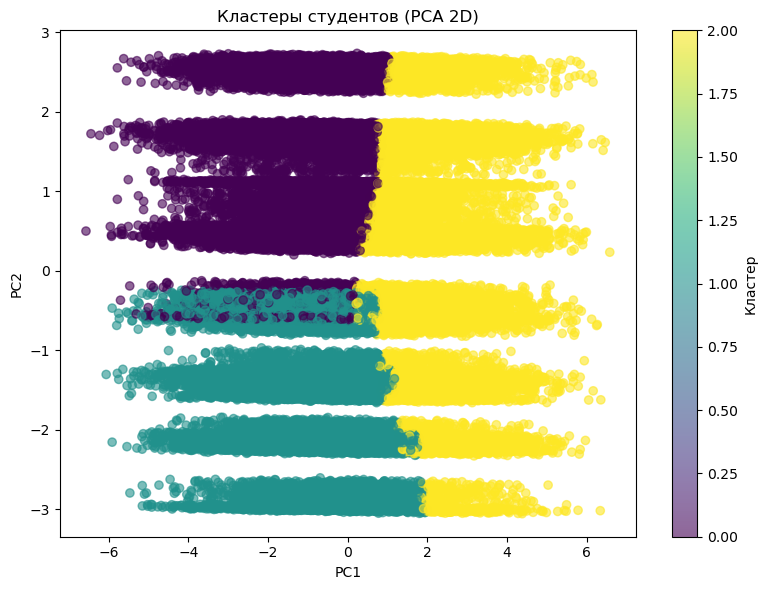

In [26]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1. Подготовим признаки так же, как перед кластеризацией
X_prepared = preprocess_clust.fit_transform(X_clust)

# 2. PCA до 2 компонент (для рисования)
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_prepared)

# 3. Если у тебя ещё нет столбца cluster в df — добавим
df["cluster"] = cluster_labels   # или свои метки, если иной объект

# 4. Рисуем scatter plot
plt.figure(figsize=(8, 6))

scatter = plt.scatter(
    X_2d[:, 0],
    X_2d[:, 1],
    c=df["cluster"],     # цвет по номеру кластера
    alpha=0.6
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Кластеры студентов (PCA 2D)")

# цветовая легенда с номерами кластеров
cbar = plt.colorbar(scatter)
cbar.set_label("Кластер")

plt.tight_layout()
plt.show()


## AffinityPropagation

In [45]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt


In [41]:
# Целевая колонка – не нужна для кластеризации
TARGET_COL = "Completed"  # если другое имя – поменяй

# Признаки для кластеризации
X_clust = df.drop(columns=[TARGET_COL])

# Разделяем на числовые и категориальные признаки
categorical_cols = X_clust.select_dtypes(include=["object", "category"]).columns.tolist()
numeric_cols = X_clust.select_dtypes(exclude=["object", "category"]).columns.tolist()

print("Категориальные признаки:", categorical_cols)
print("Числовые признаки:", numeric_cols)


Категориальные признаки: ['Gender', 'Education_Level', 'Employment_Status', 'City', 'Device_Type', 'Internet_Connection_Quality', 'Course_Name', 'Category', 'Course_Level', 'Payment_Mode', 'Fee_Paid', 'Discount_Used']
Числовые признаки: ['Age', 'Course_Duration_Days', 'Instructor_Rating', 'Login_Frequency', 'Average_Session_Duration_Min', 'Video_Completion_Rate', 'Discussion_Participation', 'Time_Spent_Hours', 'Days_Since_Last_Login', 'Notifications_Checked', 'Peer_Interaction_Score', 'Assignments_Submitted', 'Assignments_Missed', 'Quiz_Attempts', 'Quiz_Score_Avg', 'Project_Grade', 'Progress_Percentage', 'Rewatch_Count', 'Payment_Amount', 'App_Usage_Percentage', 'Reminder_Emails_Clicked', 'Support_Tickets_Raised', 'Satisfaction_Rating', 'cluster', 'cluster_dbscan']


In [43]:
numeric_transformer = StandardScaler()

categorical_transformer = OneHotEncoder(
    handle_unknown="ignore",
    sparse_output=False  
)

preprocess_spectral = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

# Преобразуем все данные
X_prepared = preprocess_spectral.fit_transform(X_clust)
print("Форма X_prepared:", X_prepared.shape)


Форма X_prepared: (100000, 84)


In [ ]:
n_clusters = 4  # выбери число кластеров, которое хочешь

spectral = SpectralClustering(
    n_clusters=n_clusters,
    affinity="nearest_neighbors",  # чаще лучше, чем rbf для табличных данных
    n_neighbors=15,                # число соседей в графе
    assign_labels="kmeans",
    random_state=42
)

labels_spectral = spectral.fit_predict(X_prepared)

df["cluster_spectral"] = labels_spectral

print("Уникальные кластеры:", np.unique(labels_spectral))
print("Распределение по кластерам:")
print(df["cluster_spectral"].value_counts())


In [ ]:
pca_vis = PCA(n_components=2, random_state=42)
X_2d = pca_vis.fit_transform(X_prepared)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_2d[:, 0],
    X_2d[:, 1],
    c=df["cluster_spectral"],
    cmap="tab10",
    alpha=0.6
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Кластеры студентов (SpectralClustering + PCA 2D)")

cbar = plt.colorbar(scatter)
cbar.set_label("cluster_spectral")

plt.tight_layout()
plt.show()
